PostProcessing Lateral

In [186]:
import cv2
from pathlib import Path
import numpy as np
from matplotlib import pyplot as plt
import math
import pandas as pd
from scipy.signal import savgol_filter
from scipy.signal import medfilt
from sklearn.cluster import DBSCAN

Import video

In [187]:
video_number = "3"
# Define the relative path to the video file
notebook_dir = Path().resolve()
project_root = notebook_dir.parent.parent
video_path = (
    project_root
    / "data"
    / f"recording_{video_number}"
    / f"Recording_{video_number}.mp4"
)
video_path = str(video_path)

# Load the video
cap = cv2.VideoCapture(video_path)

# Check
print(
    f"Opened: {cap.isOpened()}, FPS: {cap.get(cv2.CAP_PROP_FPS)}, Total Frames: {cap.get(cv2.CAP_PROP_FRAME_COUNT)}"
)

Opened: True, FPS: 59.94005994005994, Total Frames: 227.0


Background movement with optical flow

In [188]:
""" Import data of the movement from Camera_Motion_Test.ipynb """
avg_movement_list = [0.57, 3.86, 5.18, 0.10, 0.16, 3.26, 0.52]
avg_movement = avg_movement_list[int(video_number) - 1]
print(f"Average movement video {int(video_number)}: {avg_movement}")

Average movement video 3: 5.18


Import Lines

In [189]:
# Define the path to the CSV file
input_data_path = (
    project_root
    / "notebook"
    / "lane_detection"
    / "intermediate_data"
    / "lane_lines"
    / f"three_lines_{video_number}.csv"
)

# Load the CSV file into a DataFrame
lines = pd.read_csv(input_data_path)


# convert string to list
for i in range(0, len(lines)):
    for j in range(0, 3):
        lines.iloc[i][j] = np.fromstring(lines.iloc[i][j].strip("[]"), sep=" ")
        lines.iloc[i][j] = lines.iloc[i][j].tolist()
        if (
            lines.iloc[i][j][0] == 0
            and lines.iloc[i][j][1] == 0
            and lines.iloc[i][j][2] == 0
            and lines.iloc[i][j][3] == 0
        ):
            lines.iloc[i][j] = None

C:\Users\miche\AppData\Local\Temp\ipykernel_21100\2623945970.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  lines.iloc[i][j] = np.fromstring(lines.iloc[i][j].strip("[]"), sep=" ")
C:\Users\miche\AppData\Local\Temp\ipykernel_21100\2623945970.py:11: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values

Funzioni

Disegna la linea sul frame

In [190]:
"""Disegna la linea sul frame"""


def write_line_on_frame(frame, line):
    # Create a copy of the original frame to draw the first line
    modified_frame = np.copy(frame)

    # Extract the first line's rho and theta
    if line is not None:
        x1, y1, x2, y2 = line

        # Draw the first line on the frame
        cv2.line(modified_frame, (int(x1), int(y1)), (int(x2), int(y2)), (0, 255, 0), 2)

    # return the modified frame
    return modified_frame

Disegna tutte le linee su frame

In [191]:
def write_lines_on_frame(frame, lines):
    for i in range(len(lines)):
        # print('linea', i, ':', lines[i])
        frame = write_line_on_frame(frame, lines[i])
    return frame

Calcola il punto di intersezione tra la mia linea e la linea ortogonale che passa per l'oorigine

In [192]:
def find_closest_points(lines):
    # # Nuova riga da aggiungere
    # new_row = {'Frame': 100, 'X': 123.4, 'Y': 567.8}

    # # Aggiungi la riga
    # df = pd.concat([df, pd.DataFrame([new_row])], ignore_index=True)

    # create a proper DataFrame
    closest_points_df = pd.DataFrame(columns=["X", "Y"])

    # closest_points = []
    for index, row in lines.iterrows():
        line = [row["X1"], row["Y1"], row["X2"], row["Y2"]]
        if line is None or all(v == 0 for v in line):
            new_row = {"Frame": row["Frame"], "X": 0, "Y": 0}
            closest_points_df = pd.concat(
                [closest_points_df, pd.DataFrame([new_row])], ignore_index=True
            )
            continue
        x1, y1, x2, y2 = line
        # Line equation: ax + by + c = 0
        a = y2 - y1
        b = x1 - x2
        c = x2 * y1 - x1 * y2

        # Closest point to the origin (0, 0) on the line
        denom = a**2 + b**2
        x_closest = -a * c / denom
        y_closest = -b * c / denom
        # closest_points.append((x_closest, y_closest))

        new_row = {"Frame": row["Frame"], "X": x_closest, "Y": y_closest}
        closest_points_df = pd.concat(
            [closest_points_df, pd.DataFrame([new_row])], ignore_index=True
        )

    # # create a proper DataFrame
    # closest_points_df = pd.DataFrame(closest_points, columns=["X", "Y"])
    # closest_points_df['Frame'] = range(len(closest_points_df))
    # closest_points_df = closest_points_df[['Frame', 'X', 'Y']]

    return closest_points_df

Rimuove gli outliers -- non utilizzato

In [193]:
def remove_outliers(df, threshold=1):
    # Ensure 'X' and 'Y' are numeric
    df[["X", "Y"]] = df[["X", "Y"]].apply(pd.to_numeric, errors="coerce")
    print(len(df))

    # # remove the points that are 0,0
    # df = df[(df['X'] != 0) | (df['Y'] != 0)]
    # # print(len(df))

    # Compute the distance between consecutive points
    dx = df["X"].diff()
    dy = df["Y"].diff()
    distances = np.sqrt(dx**2 + dy**2)

    # print the indeces of the remaining point
    print("Remaining points:", df.index.values.tolist())

    # Define outlier threshold
    median_dist = distances.median()
    std_dist = distances.std()
    outlier_threshold = threshold * std_dist

    mask = []

    for i in df.index.values:
        # Remove points that are  (0, 0)  (the ones that I set when it doesn't detect any line)
        if df["X"].iloc[i] == 0 and df["Y"].iloc[i] == 0:
            mask.append(i)
            prev_index = i - 1
            while prev_index in mask and prev_index >= 0:
                prev_index -= 1
            if prev_index < 0:
                print("No valid previous index found. Breaking.")
                break
            # distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
            continue
        if distances[i] > outlier_threshold:
            # Create a mask to identify the outlier point
            mask.append(i)
            # convert the next point distance in the distance with respect to the previous point
            if i < len(distances) - 1 and i > 0:
                # select the previous point as the last point evaluated non present in the mask
                prev_index = i - 1
                while prev_index in mask and prev_index >= 0:
                    prev_index -= 1
                if prev_index < 0:
                    print("No valid previous index found. Breaking.")
                    break
                # distances[i+1] = np.sqrt((df['X'].iloc[i+1] - df['X'].iloc[prev_index])**2 + (df['Y'].iloc[i+1] - df['Y'].iloc[prev_index])**2)
    # Remove the outlier points from the DataFrame
    if distances[len(distances) - 1] > outlier_threshold:
        mask.append[len(df) - 1]
    df = df.drop(mask)

    # # compute distances
    # df['distance'] = np.sqrt(dx**2 + dy**2)
    # print(len(df))

    # # set the threshold
    # threshold_dist = 2 * np.mean(df['distance'])
    # # remove outliers
    # df = df[(df['distance'] < threshold_dist) & df['distance'].notna()]  # the first value is considered as correct

    return df

Remove outliers DBSCAN

In [194]:
def remove_outliers_dbscan(df):
    # remove the points that are 0,0
    df = df[(df["X"] != 0) | (df["Y"] != 0)]

    # df deve avere colonne 'X' e 'Y'
    X = df[["X", "Y"]].values

    db = DBSCAN(eps=30, min_samples=5).fit(X)
    """
    eps = 5: distanza massima tra due punti per essere considerati nello stesso cluster
    min_samples = 10: numero minimo di punti per formare un cluster
    """
    df["label"] = db.labels_

    # Rimuove i punti classificati come noise (-1)
    df_clean = df[df["label"] != -1]

    return df_clean

Plot the coordinates

In [195]:
def plot_coordinates(
    df, title="Coordinates Plot", xlabel="X", ylabel="Y", save_path=None
):
    # compute the mean and std of the X and Y coordinates
    mean_x = df["X"].mean()
    std_x = df["X"].std()
    mean_y = df["Y"].mean()
    std_y = df["Y"].std()
    # plot the values of x and y with the mean and std
    plt.figure(figsize=(10, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df["X"], label="X")
    plt.axhline(mean_x, color="r", linestyle="--", label="Mean")
    plt.axhline(mean_x + std_x, color="g", linestyle="--", label="Mean + Std")
    plt.axhline(mean_x - std_x, color="g", linestyle="--", label="Mean - Std")
    plt.title(title)
    plt.xlabel("Frame")
    plt.ylabel("X")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(df["Y"], label="Y")
    plt.axhline(mean_y, color="r", linestyle="--", label="Mean")
    plt.axhline(mean_y + std_y, color="g", linestyle="--", label="Mean + Std")
    plt.axhline(mean_y - std_y, color="g", linestyle="--", label="Mean - Std")
    plt.title(title)
    plt.xlabel("Frame")
    plt.ylabel("Y")
    plt.legend()
    plt.grid()
    plt.tight_layout()
    plt.show()

remove outliers in a window

In [196]:
def remove_outliers_xy(df):
    # compute the mean and std of the X and Y coordinates
    mean_x = df["X"].mean()
    std_x = df["X"].std()
    mean_y = df["Y"].mean()
    std_y = df["Y"].std()

    # set the threshold
    threshold_x = std_x * 2
    threshold_y = std_y * 2
    # remove outliers: remove the points that have a distance on each axis with respect to the previous point greater than the threshold
    mask = []
    for i in range(len(df.index.values)):
        if df["X"].iloc[i] == 0 and df["Y"].iloc[i] == 0:
            mask.append(df.index.values[i])
            continue
        # compute the first feasible previous index
        prev_index = i - 1
        while df.index.values[prev_index] in mask and prev_index >= 0:
            prev_index -= 1
        if (
            abs(df["X"].iloc[i] - df["X"].iloc[prev_index]) > threshold_x
            or abs(df["Y"].iloc[i] - df["Y"].iloc[prev_index]) > threshold_y
        ) and prev_index >= 0:
            mask.append(df.index.values[i])

    # Remove the outlier points from the DataFrame
    df = df.drop(mask)

    return df

rimuove gli outliers con un algotimo iterato

In [197]:
def remove_outliers_iterated(df, threshold_factor=1):
    # Ensure 'X' and 'Y' are numeric
    df[["X", "Y"]] = df[["X", "Y"]].apply(pd.to_numeric, errors="coerce")

    first_iteration = True
    exit_threshold = 10000
    max_dist = np.inf

    # remove the points that are 0,0
    df = df[(df["X"] != 0) | (df["Y"] != 0)]

    # Compute the distance between consecutive points
    dx = df["X"].diff()
    dy = df["Y"].diff()

    # compute distances
    df["distance"] = np.sqrt(dx**2 + dy**2)

    while max_dist > exit_threshold:
        # set the threshold to exit the while
        if first_iteration:
            first_iteration = False
            mean_dist = np.mean(df["distance"])
            std = np.std(df["distance"])
            print("media:", mean_dist, "std:", std)
            if std > mean_dist:
                exit_threshold = std
            else:
                exit_threshold = 2 * mean_dist

        # set the threshold for outliers removal
        if threshold_factor > 1:
            threshold_dist = threshold_factor * np.mean(df["distance"])
        else:
            threshold_dist = 1 * np.mean(df["distance"])

        # outliers removal
        df = df[
            (df["distance"] < threshold_dist) & df["distance"].notna()
        ]  # the first value is considered as correct

        # Compute the distance between consecutive points
        dx = df["X"].diff()
        dy = df["Y"].diff()

        # compute distances
        df["distance"] = np.sqrt(dx**2 + dy**2)

        # get the max distance
        max_dist = np.max(df["distance"])

    return df

Calcola la slope delle linee

In [198]:
# Function to calculate the angle of a line
def calculate_angle(x1, y1, x2, y2):
    return math.degrees(math.atan2(y2 - y1, x2 - x1))

slope outliers remotion

In [199]:
def remove_outliers_slope(lines_df):
    # aggiungi una colonna al df con l'angolo calcolato con la funzione calculate_angle
    lines_df["slope"] = lines_df.apply(
        lambda row: calculate_angle(row["X1"], row["Y1"], row["X2"], row["Y2"]), axis=1
    )
    # calcola la media e lo std dell'angolo
    mean_angle = lines_df["slope"].mean()
    std_angle = lines_df["slope"].std()

    # calcola il limite di tolleranza
    tolerance = std_angle

    # filtra le righe in base all'angolo e imposta le coordinate a 0 se fuori dalla tolleranza
    # filtered_lines = lines_df[(lines_df['slope'] >= mean_angle - tolerance) & (lines_df['slope'] <= mean_angle + tolerance)]

    lines_df.loc[
        (lines_df["slope"] < mean_angle - tolerance)
        | (lines_df["slope"] > mean_angle + tolerance),
        ["X1", "Y1", "X2", "Y2"],
    ] = 0

    filtered_lines = lines_df

    return filtered_lines

Smoothing con filtro a media mobile

In [200]:
def median_filter(df, kernel_size=3):
    """
    Smooths the X and Y coordinates using a median filter to reduce noise.
    """
    # Apply a median filter to smooth the coordinates (kernel size 3 by default)
    df["X"] = medfilt(df["X"], kernel_size=kernel_size)
    df["Y"] = medfilt(df["Y"], kernel_size=kernel_size)

    return df

Smoothing

In [201]:
def Savitzky_Golay_filter(df, window_length=5, polyorder=3):
    """
    Smooths the X and Y coordinates using Savitzky-Golay filter to reduce noise.
    """
    df["X"] = savgol_filter(df["X"], window_length=window_length, polyorder=polyorder)
    df["Y"] = savgol_filter(df["Y"], window_length=window_length, polyorder=polyorder)

    return df

In [202]:
def interpolate_missing_coordinates(df, end_frame, start_frame=0):
    """
    Interpolate the missing coordinates between the frames from start_frame to end_frame.
    Ensures a smooth trajectory by interpolating both X and Y coordinates.
    """
    # Create a DataFrame with all frames from start_frame to end_frame
    all_frames = pd.DataFrame({"Frame": range(start_frame, end_frame + 1)})

    # Merge with the original dataframe
    df_full = pd.merge(all_frames, df, on="Frame", how="left")

    # Interpolate the missing 'X' and 'Y' coordinates (linear interpolation)
    df_full["X"] = df_full["X"].interpolate(method="linear")
    df_full["Y"] = df_full["Y"].interpolate(method="linear")

    # Fill any remaining NaN values using forward and backward filling
    df_full["X"] = df_full["X"].bfill().ffill()
    df_full["Y"] = df_full["Y"].bfill().ffill()

    # Apply smoothing to ensure a smooth trajectory
    df_full = Savitzky_Golay_filter(df_full)

    return df_full

Plotta le traiettorie

In [203]:
def plot_trajectory(df, title):
    plt.figure(figsize=(8, 6))
    plt.plot(df["X"], -df["Y"], "o-", label="Cleaned Trajectory")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.title(title)
    plt.legend()
    plt.show()

Ricalcola le linee dai punti

In [204]:
def points_to_lines(df, line_length=1):
    lines = []
    for i in range(0, len(df)):
        x, y = df.iloc[i]["X"], df.iloc[i]["Y"]
        # Compute the direction vector orthogonal to the line connecting the point to the origin
        dx, dy = (
            -y,
            x,
        )  # Rotate the vector (x, y) by 90 degrees to get orthogonal direction

        # Append the line as a pair of points
        lines.append(
            [
                int(x + line_length * dx),
                int(y + line_length * dy),
                int(x - line_length * dx),
                int(y - line_length * dy),
            ]
        )

    return lines

Algoritmo di postprocessing di un set di linee

In [ ]:
def adjust_lines(lines, avg_movement):
    # create a lines df
    # lines_df = pd.DataFrame(range(len(lines)), lines, columns=['Frame', 'X1', 'Y1', 'X2', 'Y2'])

    # Se lines è una Series o lista di array/liste
    lines_with_frames = [
        [frame_idx] + list(line) for frame_idx, line in enumerate(lines)
    ]

    # Ora creiamo il DataFrame
    lines_df = pd.DataFrame(
        lines_with_frames, columns=["Frame", "X1", "Y1", "X2", "Y2"]
    )

    lines_cleaned = remove_outliers_slope(lines_df)
    # find the point of the lines closet to the origin and create the proper dataframe
    closest_points_df = find_closest_points(lines_cleaned)
    # plot_trajectory(closest_points_df, "raw points")
    plot_coordinates(closest_points_df, "raw points")

    if avg_movement > 1:
        # Remove outliers with DBSCAN
        points_cleaned_dbscan = remove_outliers_dbscan(closest_points_df)
        # plot_trajectory(points_cleaned_dbscan, "cleaned points after DBSCAN")
        plot_coordinates(points_cleaned_dbscan, "cleaned points DBSCAN")

        # Remove outliers with a distance threshold
        points_cleaned = remove_outliers_xy(points_cleaned_dbscan)
        # plot_trajectory(points_cleaned, "cleaned points")
        plot_coordinates(points_cleaned, "cleaned points")

        # # Smooth the trajectory to reduce noise
        # points_smoothed = median_filter(points_cleaned)
        # # plot_trajectory(points_smoothed, "smoothed points")
        # plot_coordinates(points_smoothed, "smoothed points")

        # Interpolate missing coordinates
        points_interpolated = interpolate_missing_coordinates(
            points_cleaned, len(lines) - 1
        )
        # plot_trajectory(points_interpolated, "interpolated points")
        plot_coordinates(points_interpolated, "interpolated points")

        adjusted_lines = points_to_lines(points_interpolated)
    else:
        # Remove outliers iterated
        points_cleaned = remove_outliers_iterated(
            closest_points_df, threshold_factor=avg_movement
        )
        # plot_trajectory(points_cleaned, "cleaned points iterated")
        plot_coordinates(points_cleaned, "cleaned points iterated")

        # get the mean point because I'm assuming the video still
        mean_point = points_cleaned.mean()
        # print('mean point:', mean_point)

        # create a list of length of the original df where each element is mean_point
        mean_point_list = [mean_point] * len(closest_points_df)
        mean_point_df = pd.DataFrame(mean_point_list, columns=["X", "Y"])

        # plot_trajectory(mean_point_df, "mean points")

        adjusted_lines = points_to_lines(mean_point_df)

    return adjusted_lines

Main

In [206]:
def process_lines(lines, avg_movement=1):
    left_lines, right_lines = lines.iloc[:, 1], lines.iloc[:, 2]
    left_lines_processed = adjust_lines(left_lines, avg_movement=avg_movement)
    right_lines_processed = adjust_lines(right_lines, avg_movement=avg_movement)
    processed_lines = []
    print(
        "len left:",
        len(left_lines_processed),
        "len right:",
        len(right_lines_processed),
        "len lines:",
        len(lines),
    )
    for i in range(len(left_lines_processed)):
        processed_lines.append(
            [lines.iloc[i, 0], left_lines_processed[i], right_lines_processed[i]]
        )
    return processed_lines

Modify Video

C:\Users\miche\AppData\Local\Temp\ipykernel_21100\563631844.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  closest_points_df = pd.concat([closest_points_df, pd.DataFrame([new_row])], ignore_index=True)


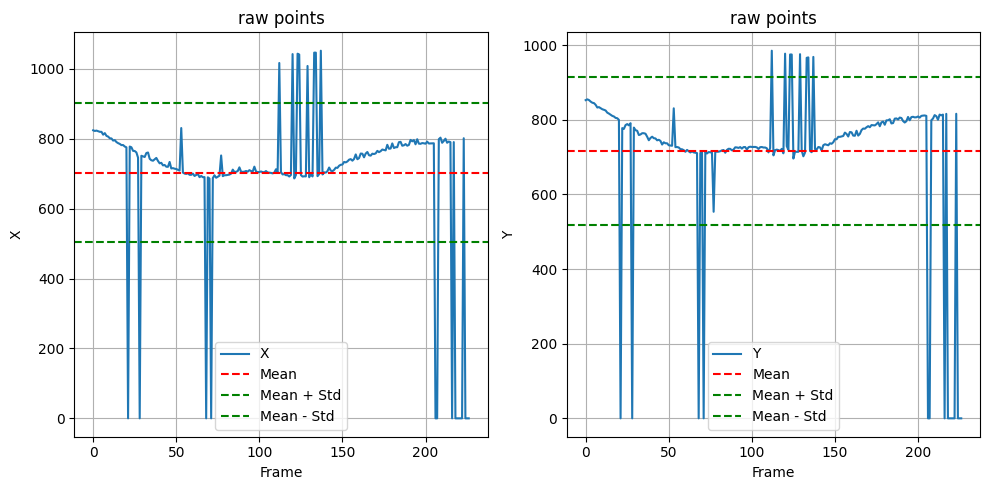

C:\Users\miche\AppData\Local\Temp\ipykernel_21100\1766701223.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = db.labels_


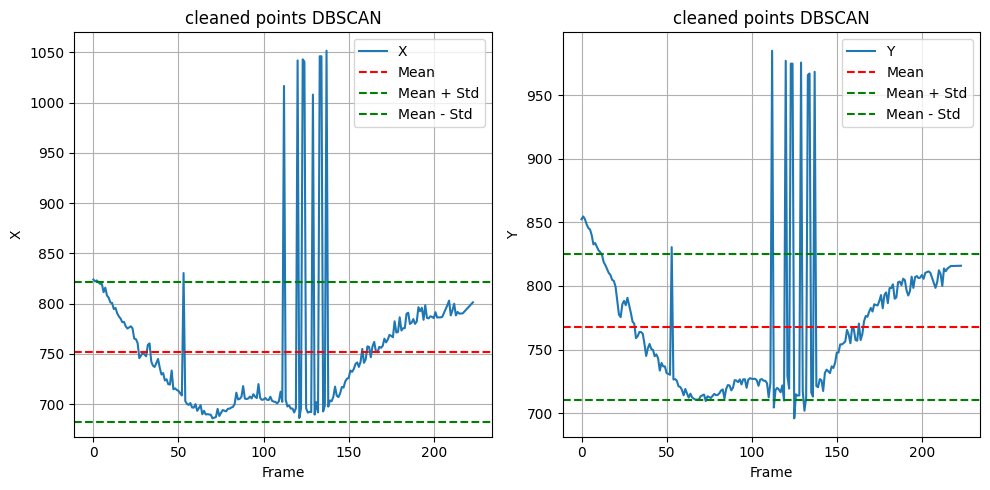

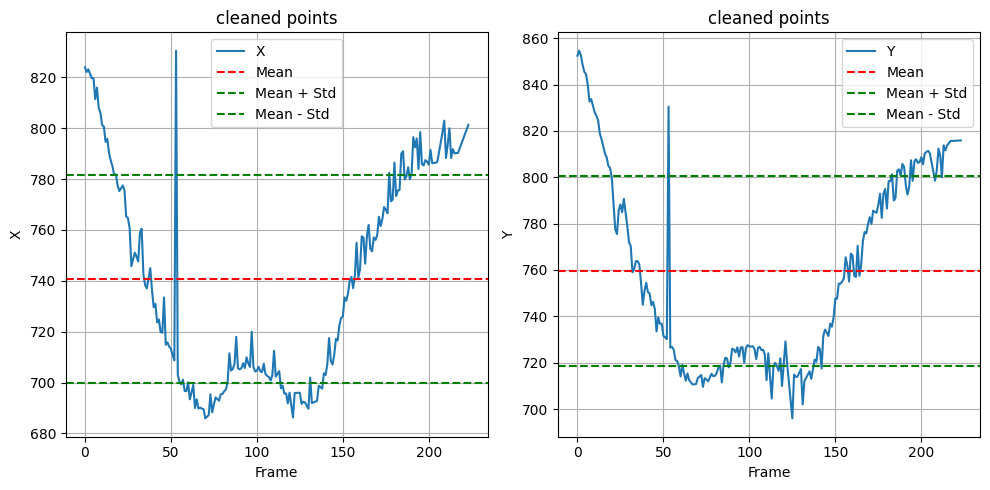

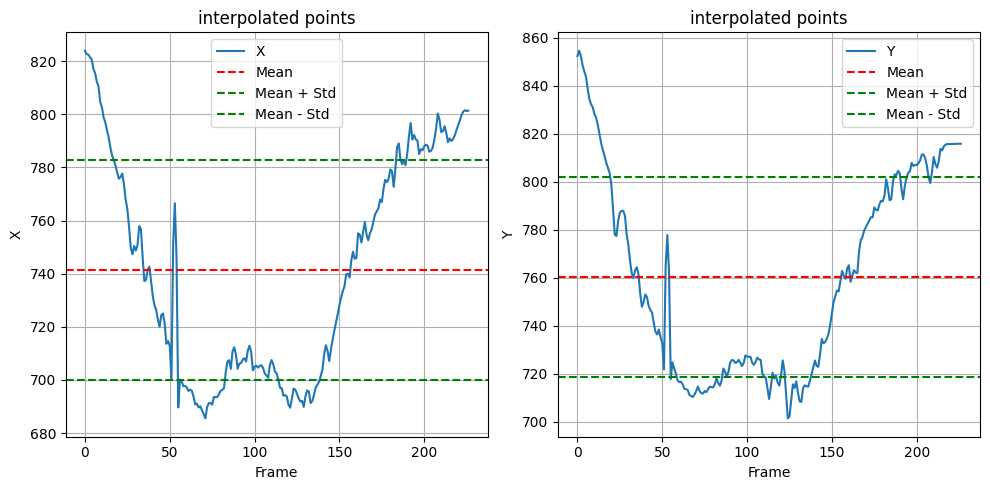

C:\Users\miche\AppData\Local\Temp\ipykernel_21100\563631844.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  closest_points_df = pd.concat([closest_points_df, pd.DataFrame([new_row])], ignore_index=True)


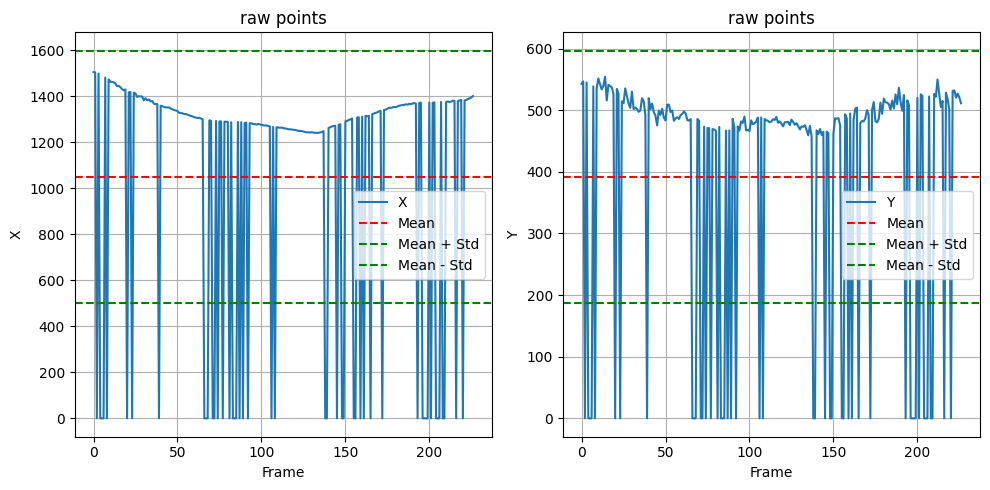

C:\Users\miche\AppData\Local\Temp\ipykernel_21100\1766701223.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['label'] = db.labels_


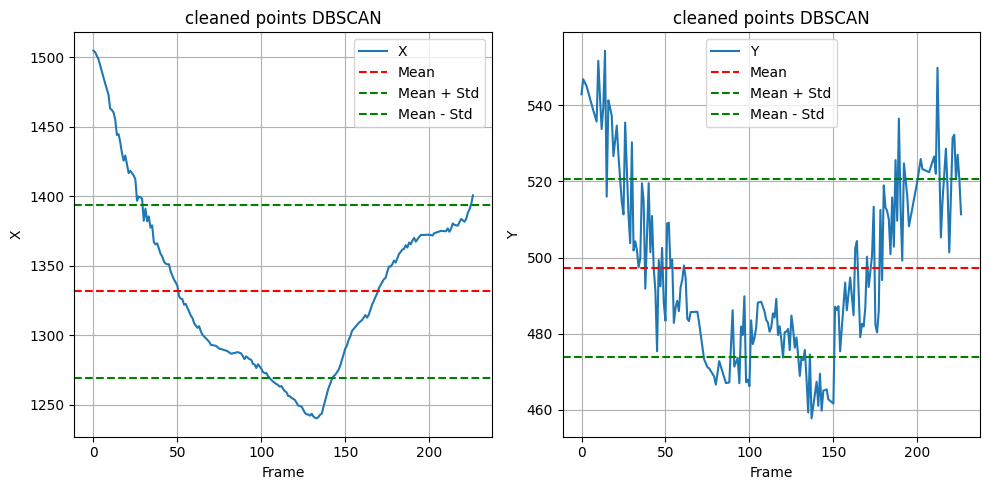

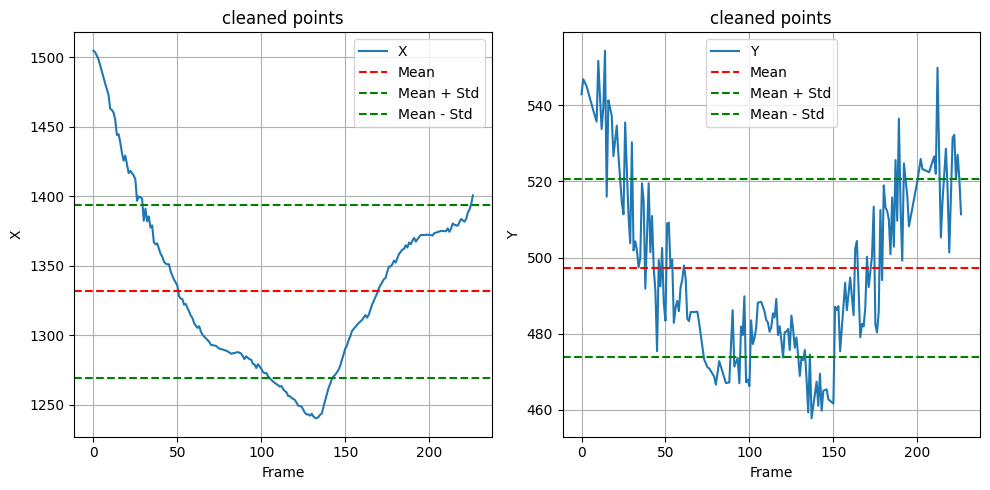

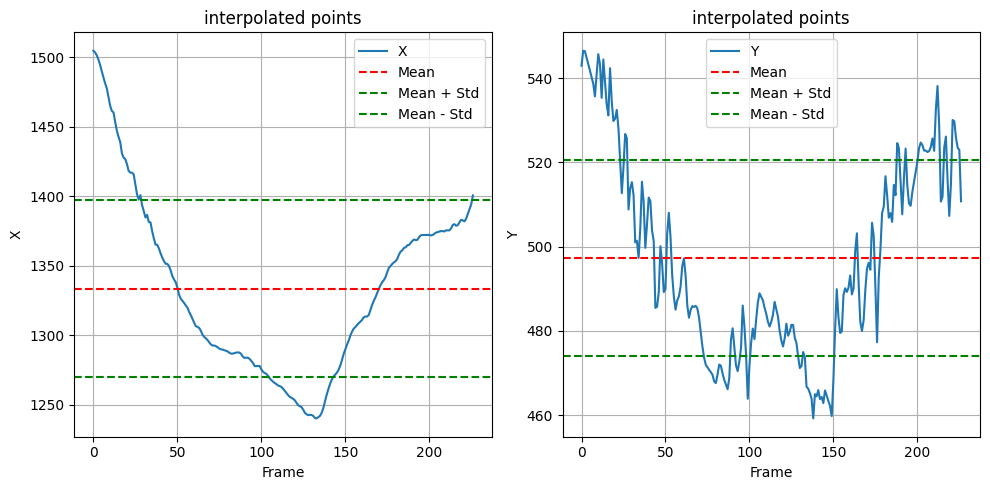

len left: 227 len right: 227 len lines: 227
Processed lines: 227 original lines: 227
Adjusted video saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\data\recording_3\Lines_video_processed.mp4


In [207]:
# Reset the video to the beginning
cap.set(cv2.CAP_PROP_POS_FRAMES, 0)

# Define the codec and create a VideoWriter object to save the modified frames
output_path = (
    project_root / "data" / f"recording_{video_number}" / "Lines_video_processed.mp4"
)
fourcc = cv2.VideoWriter_fourcc(*"mp4v")  # Use 'mp4v' codec for MP4 format
fps = int(cap.get(cv2.CAP_PROP_FPS))
frame_width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
frame_height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
out = cv2.VideoWriter(str(output_path), fourcc, fps, (frame_width, frame_height))

# Process the lines
processed_lines = process_lines(lines, avg_movement=avg_movement)
print("Processed lines:", len(processed_lines), "original lines:", len(lines))

# initializing df
output_df = pd.DataFrame(columns=["frame_number", "horizontal", "left", "right"])

# Loop through each frame in the video
frame_index = 0
while frame_index < len(lines):
    ret, video_frame = cap.read()
    if not ret:
        print("End of video or failed to read the frame at iteration", frame_index)
        break
    # print(f"Processing frame {frame_index}")

    # draw the lines on the frame
    modified_frame = write_lines_on_frame(video_frame, processed_lines[frame_index])

    # add lines to the output df
    output_df.loc[len(output_df)] = [
        frame_index,
        processed_lines[frame_index][0],
        processed_lines[frame_index][1],
        processed_lines[frame_index][2],
    ]

    # Write the modified frame to the output video
    out.write(modified_frame)

    # Increment the frame index
    frame_index += 1

# Release the video capture and writer objects
# cap.release()
out.release()

print(f"Adjusted video saved to {output_path}")

Save lines

In [208]:
# Define the output path for the lines CSV file
output_lines_path = (
    project_root
    / "notebook"
    / "lane_detection"
    / "intermediate_data"
    / "lane_lines"
    / f"definitive_lines_{video_number}.csv"
)

# Create a DataFrame with the specified columns
output_lines_df = pd.DataFrame(
    columns=[
        "Frame",
        "hx1",
        "hy1",
        "hx2",
        "hy2",
        "lx1",
        "ly1",
        "lx2",
        "ly2",
        "rx1",
        "ry1",
        "rx2",
        "ry2",
    ]
)

# Populate the DataFrame with data from output_df
for index, row in output_df.iterrows():
    frame_data = {
        "Frame": row["frame_number"],
        "hx1": row["horizontal"][0],
        "hy1": row["horizontal"][1],
        "hx2": row["horizontal"][2],
        "hy2": row["horizontal"][3],
        "lx1": row["left"][0],
        "ly1": row["left"][1],
        "lx2": row["left"][2],
        "ly2": row["left"][3],
        "rx1": row["right"][0],
        "ry1": row["right"][1],
        "rx2": row["right"][2],
        "ry2": row["right"][3],
    }
    output_lines_df = pd.concat(
        [output_lines_df, pd.DataFrame([frame_data])], ignore_index=True
    )

# Add the data to output_df
# output_df = lines_array


# Convert lines_array to a DataFrame
lines_df = pd.DataFrame(output_lines_df)

# Save the DataFrame to a CSV file
lines_df.to_csv(output_lines_path, index=False)

print(f"Lines array saved to {output_lines_path}")

Lines array saved to C:\Users\miche\OneDrive\Documenti\GitHub\bowling-analysis\notebook\lane_detection\intermediate_data\lane_lines\definitive_lines_3.csv


C:\Users\miche\AppData\Local\Temp\ipykernel_21100\2940220669.py:15: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_lines_df = pd.concat([output_lines_df, pd.DataFrame([frame_data])], ignore_index=True)
